# SeqRep Test

## Outlier Variant Generation

In [1]:
import numpy as np
BASES = np.array(['A', 'C', 'G', 'T'])

class SyntheticGenerator:
    def __init__(self, size: int, mut_prob: float):
        self.rng = np.random.default_rng()
        self.base_seq = self.rng.integers(0, 4, size)
        self.mut_prob = mut_prob
    
    def gen(self):
        mutation = self.rng.random(len(self.base_seq)) < self.mut_prob
        to_add = self.rng.integers(0, 4, len(self.base_seq))[mutation]
        new = np.copy(self.base_seq)
        new[mutation] = (new[mutation] + to_add) % 4
        return ''.join(BASES[new])

## Preprocessing

In [25]:
from SeReGen.dataset_builder import DatasetBuilder, SILVA_header_parser
builder = DatasetBuilder(SILVA_header_parser)
dataset = builder.from_fasta(['SILVA_138.1_SSURef_NR99_tax_silva.fasta'])
# dataset = builder.from_fasta(['small.fasta'])

In [26]:
dataset = dataset.drop_bad_headers()
len(dataset)

377304

In [27]:
# Insert synthetic data
size = 10000
generator = SyntheticGenerator(1200, .01)
synthetic_seqs = [generator.gen() for _ in range(size)]

import pandas as pd
df = pd.DataFrame({
    'orig_seqs': synthetic_seqs,
    'seqs': synthetic_seqs,
    'raw_headers': ['' for _ in range(size)],
    'labels': [['SYNTHETIC'] * 7 for _ in range(size)]
})
dataset = pd.concat([dataset, df])

In [28]:
kmer_counts = dataset.count_kmers(5, jobs=55, chunksize=1000)

100%|██████████| 387304/387304 [00:03<00:00, 109742.80it/s]


## Simple Dense Network

In [92]:
from SeReGen.encoders import ModelBuilder
builder = ModelBuilder(1024)
builder.dense(512)
builder.dense(512)
builder.dense(512)
builder.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_22 (Dense)            (None, 512)               524800    
                                                                 
 batch_normalization_22 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_23 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_23 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_24 (Dense)            (None, 512)               262

In [93]:
from SeReGen.comparative_encoder import ComparativeEncoder
from SeReGen.distance import EuclideanWithoutNorm
import importlib
EuclideanWithoutNorm = importlib.reload(SeReGen.distance).EuclideanWithoutNorm
ComparativeEncoder = importlib.reload(SeReGen.comparative_encoder).ComparativeEncoder
dense_comp = ComparativeEncoder.from_model_builder(builder, repr_size=2, dist=EuclideanWithoutNorm(2),
                                                   embed_dist='hyperbolic')

In [94]:
dense_comp.fit(kmer_counts, batch_size=1000, epochs=15, jobs=55, chunksize=1000, patience=2)

Epoch 1:


100%|██████████| 387304/387304 [00:08<00:00, 46316.94it/s]


388/388 [==============================] - 7s 14ms/step - loss: 0.1998
Epoch time: 26.556941986083984
Epoch 2:


100%|██████████| 387304/387304 [00:07<00:00, 49630.87it/s]


388/388 [==============================] - 5s 13ms/step - loss: 0.1499
Epoch time: 23.782306909561157
Epoch 3:


100%|██████████| 387304/387304 [00:07<00:00, 49265.31it/s]


388/388 [==============================] - 5s 12ms/step - loss: 0.1407
Epoch time: 23.941773653030396
Epoch 4:


100%|██████████| 387304/387304 [00:07<00:00, 49106.65it/s]


388/388 [==============================] - 5s 14ms/step - loss: 0.1306
Epoch time: 24.494386911392212
Epoch 5:


100%|██████████| 387304/387304 [00:07<00:00, 48803.00it/s]


388/388 [==============================] - 5s 13ms/step - loss: 0.1267
Epoch time: 24.219680786132812
Epoch 6:


100%|██████████| 387304/387304 [00:08<00:00, 45209.85it/s]


388/388 [==============================] - 5s 13ms/step - loss: 0.1252
Epoch time: 24.763953924179077
Epoch 7:


100%|██████████| 387304/387304 [00:08<00:00, 45771.37it/s]


388/388 [==============================] - 5s 12ms/step - loss: 0.1262
Epoch time: 24.64330220222473
Epoch 8:


100%|██████████| 387304/387304 [00:08<00:00, 44865.45it/s]


388/388 [==============================] - 5s 12ms/step - loss: 0.1465
Epoch time: 24.901880979537964
Stopping early due to lack of improvement!
Total time taken: 197.35820698738098 seconds.


In [95]:
dense_reprs = dense_comp.transform(kmer_counts, batch_size=1000)

388/388 [==============================] - 3s 6ms/step


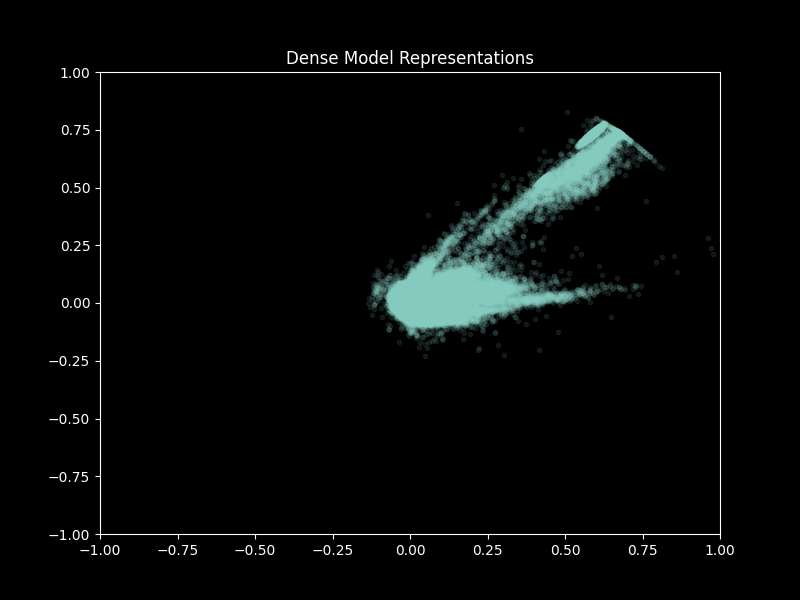

In [96]:
from SeReGen.visualize import repr_scatterplot
import importlib, SeReGen.visualize
repr_scatterplot = importlib.reload(SeReGen.visualize).repr_scatterplot
repr_scatterplot(dense_reprs, "Dense Model Representations", scale=1, savepath='out.png')
from IPython.display import Image
Image(filename='out.png')

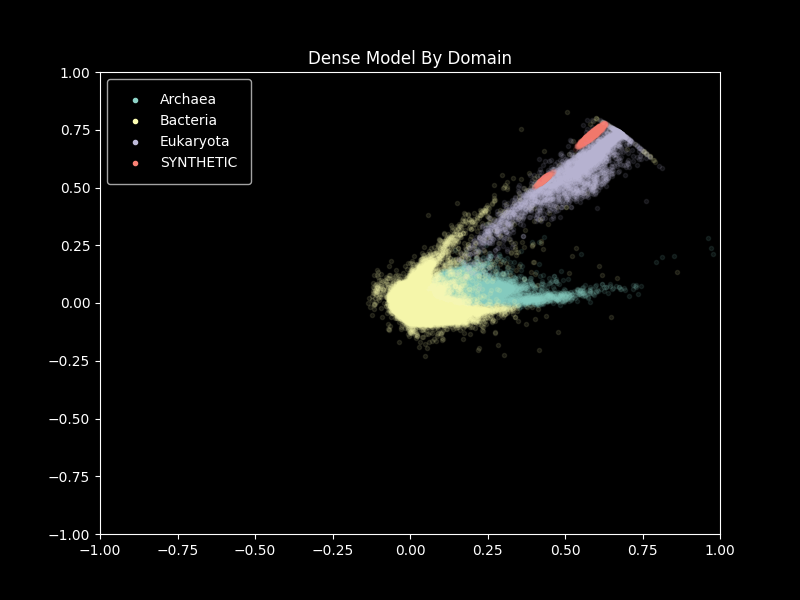

In [97]:
from SeReGen.visualize import reprs_by_ds_label
import importlib, SeReGen.visualize
reprs_by_ds_label = importlib.reload(SeReGen.visualize).reprs_by_ds_label
reprs_by_ds_label(dense_reprs, dataset, 'Domain', title='Dense Model By Domain', marker='.', alpha=.1, scale=1, savepath='out.png')
from IPython.display import Image
Image(filename='out.png')

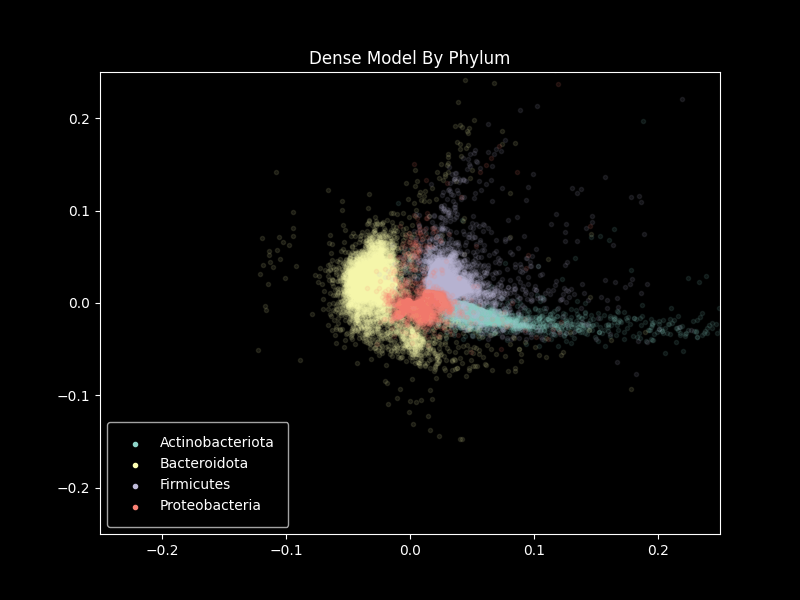

In [104]:
from SeReGen.visualize import reprs_by_ds_label
mask = dataset['labels'].label_mask('Domain', 'Bacteria')
reprs_by_ds_label(dense_reprs, dataset, 'Phylum', 'Dense Model By Phylum', filter=10000, mask=mask, marker='.',
              savepath='out.png', scale=.25)
from IPython.display import Image
Image(filename='out.png')

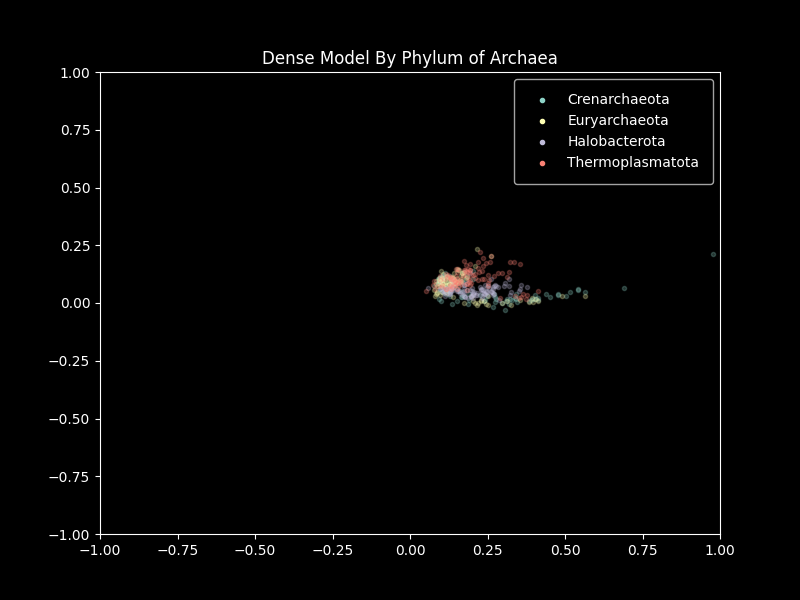

In [99]:
from SeReGen.visualize import reprs_by_ds_label
mask = dataset['labels'].label_mask('Domain', 'Archaea')
reprs_by_ds_label(dense_reprs, dataset, 'Phylum', 'Dense Model By Phylum of Archaea', filter=100, mask=mask, marker='.',
              savepath='out.png', scale=1, alpha=.25)
from IPython.display import Image
Image(filename='out.png')

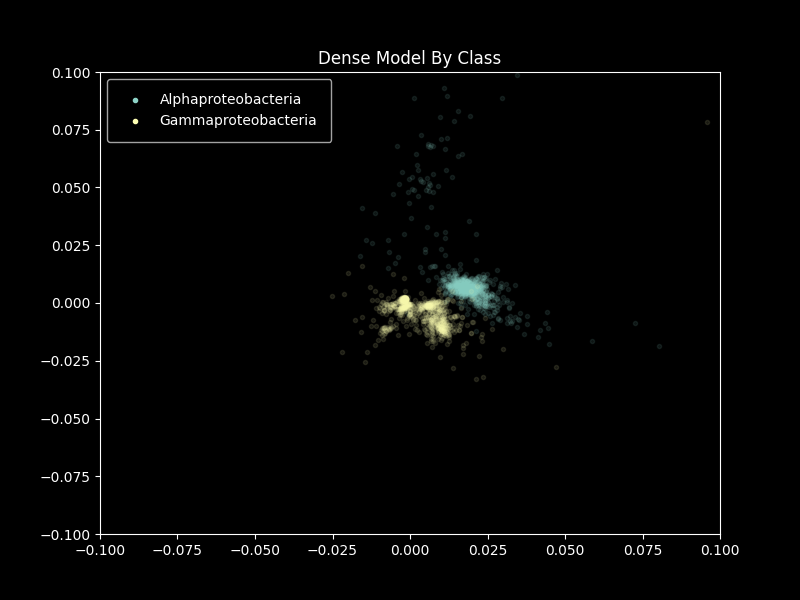

In [100]:
from SeReGen.visualize import reprs_by_ds_label
mask = dataset['labels'].label_mask('Phylum', 'Proteobacteria')
reprs_by_ds_label(dense_reprs, dataset, 'Class', 'Dense Model By Class', filter=1000, mask=mask, savepath='out.png',
              alpha=.1, marker='.', scale=.1)
from IPython.display import Image
Image(filename='out.png')

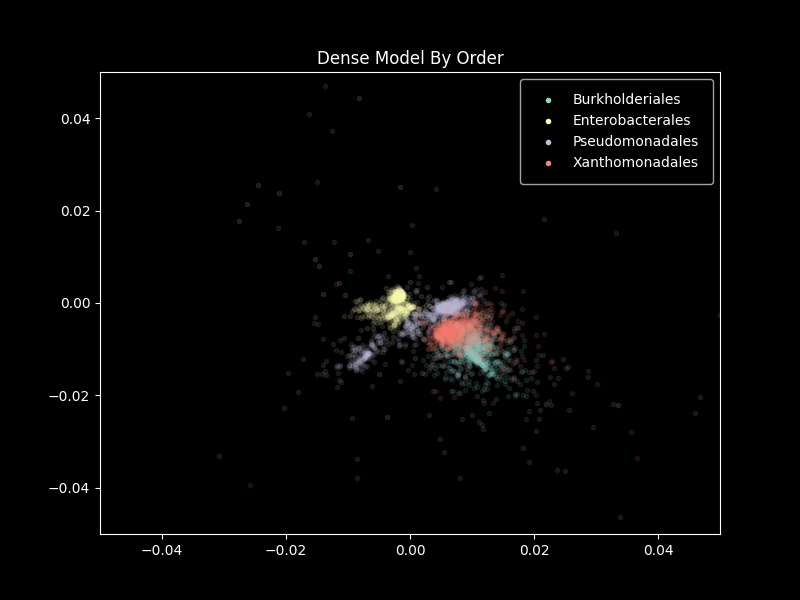

In [101]:
from SeReGen.visualize import reprs_by_ds_label
mask = dataset['labels'].label_mask('Class', 'Gammaproteobacteria')
reprs_by_ds_label(dense_reprs, dataset, 'Order', 'Dense Model By Order', filter=1000, mask=mask, savepath='out.png',
              alpha=.1, marker='.', scale=.05)
from IPython.display import Image
Image(filename='out.png')

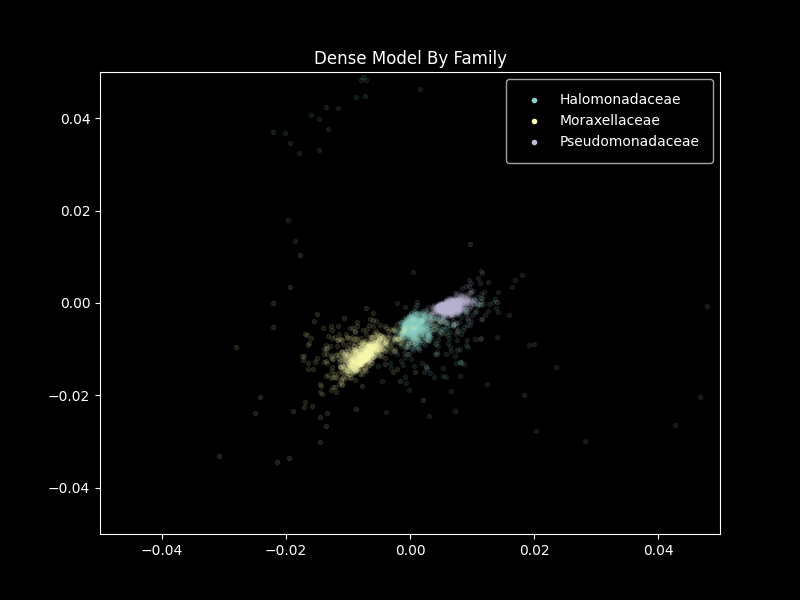

In [102]:
from SeReGen.visualize import reprs_by_ds_label
mask = dataset['labels'].label_mask('Order', 'Pseudomonadales')
reprs_by_ds_label(dense_reprs, dataset, 'Family', 'Dense Model By Family', filter=1000, mask=mask, savepath='out.png',
              alpha=.1, marker='.', scale=.05)
from IPython.display import Image
Image(filename='out.png')

In [90]:
seqs = []
for _ in range(1000):
    generator = SyntheticGenerator(1200, .01)
    seqs.append(generator.gen())

from SeReGen.kmers import KMerCounter
counter = KMerCounter(5)
counts = counter.kmer_counts(seqs)
results = dense_comp.transform(counts, 100)

100%|██████████| 1000/1000 [00:00<00:00, 3618.58it/s]


10/10 [==============================] - 0s 2ms/step


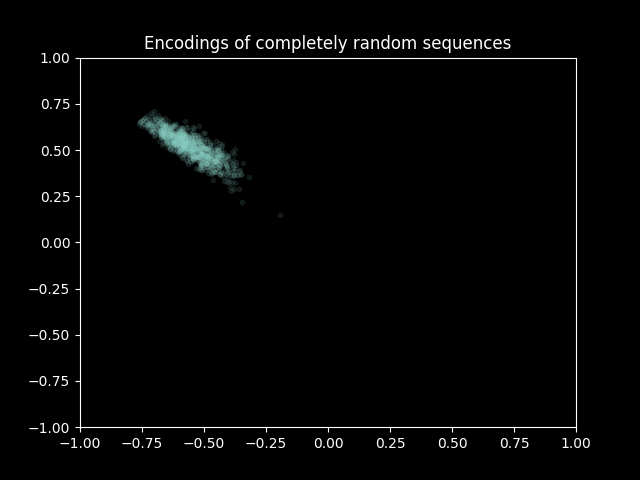

In [91]:
import matplotlib.pyplot as plt
plt.close('all')
plt.scatter(*zip(*results), alpha=.1, marker='.')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title('Encodings of completely random sequences')
plt.savefig('out.png')
from IPython.display import Image
Image(filename='out.png')

## Without Outlier Foreknowledge

In [62]:
dataset = dataset[~dataset['labels'].label_mask('Domain', 'SYNTHETIC')]  # Remove synthetic data

In [4]:
dataset = dataset[~dataset['labels'].label_mask('Domain', 'Archaea')]  # Remove archaea

In [5]:
dataset = dataset[~dataset['labels'].label_mask('Domain', 'Eukaryota')]  # Remove eukaryota

In [6]:
kmer_counts = dataset.count_kmers(5, jobs=55, chunksize=1000)

100%|██████████| 361915/361915 [00:03<00:00, 99819.00it/s] 


## Simple Dense Network

In [7]:
from SeReGen.encoders import ModelBuilder
builder = ModelBuilder(1024)
builder.dense(512)
builder.dense(512)
builder.dense(512)
builder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 512)               262656

In [8]:
from SeReGen.comparative_encoder import ComparativeEncoder
from SeReGen.distance import Euclidean
dense_comp = ComparativeEncoder.from_model_builder(builder, repr_size=2, dist=Euclidean(2), embed_dist='hyperbolic')

In [9]:
dense_comp.fit(kmer_counts, batch_size=1000, epochs=15, jobs=55, chunksize=1000, patience=2)

Epoch 1:


100%|██████████| 361915/361915 [00:06<00:00, 52473.02it/s]


362/362 [==============================] - 6s 9ms/step - loss: 0.2757
Epoch time: 20.40828537940979
Epoch 2:


100%|██████████| 361915/361915 [00:06<00:00, 53884.95it/s]


362/362 [==============================] - 3s 9ms/step - loss: 0.2309
Epoch time: 18.296821355819702
Epoch 3:


100%|██████████| 361915/361915 [00:07<00:00, 50247.85it/s]


362/362 [==============================] - 5s 13ms/step - loss: 0.2181
Epoch time: 20.2485134601593
Epoch 4:


100%|██████████| 361915/361915 [00:07<00:00, 51691.51it/s]


362/362 [==============================] - 5s 14ms/step - loss: 0.2115
Epoch time: 20.22764492034912
Epoch 5:


100%|██████████| 361915/361915 [00:07<00:00, 48996.90it/s]


362/362 [==============================] - 5s 14ms/step - loss: 0.2108
Epoch time: 20.78229069709778
Epoch 6:


100%|██████████| 361915/361915 [00:07<00:00, 48194.78it/s]


362/362 [==============================] - 5s 14ms/step - loss: 0.2104
Epoch time: 20.945051908493042
Epoch 7:


100%|██████████| 361915/361915 [00:07<00:00, 50047.21it/s]


362/362 [==============================] - 5s 14ms/step - loss: 0.2074
Epoch time: 20.713289737701416
Epoch 8:


100%|██████████| 361915/361915 [00:07<00:00, 49343.45it/s]


362/362 [==============================] - 4s 11ms/step - loss: 0.1997
Epoch time: 19.66202998161316
Epoch 9:


100%|██████████| 361915/361915 [00:07<00:00, 48331.55it/s]


362/362 [==============================] - 4s 12ms/step - loss: 0.2069
Epoch time: 20.502948760986328
Epoch 10:


100%|██████████| 361915/361915 [00:07<00:00, 49451.84it/s]


362/362 [==============================] - 4s 12ms/step - loss: 0.2032
Epoch time: 19.908278465270996
Stopping early due to lack of improvement!
Total time taken: 201.75954961776733 seconds.


In [10]:
dense_reprs = dense_comp.transform(kmer_counts, batch_size=1000)

362/362 [==============================] - 2s 6ms/step


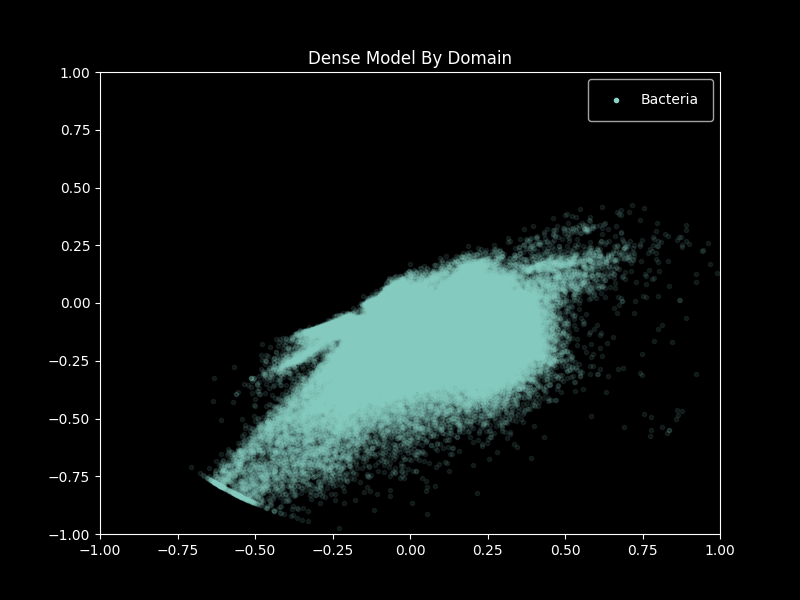

In [13]:
from SeReGen.visualize import reprs_by_ds_label
import importlib, SeReGen.visualize
reprs_by_ds_label = importlib.reload(SeReGen.visualize).reprs_by_ds_label
reprs_by_ds_label(dense_reprs, dataset, 'Domain', title='Dense Model By Domain', marker='.', alpha=.1, scale=1, savepath='out.png')
from IPython.display import Image
Image(filename='out.png')

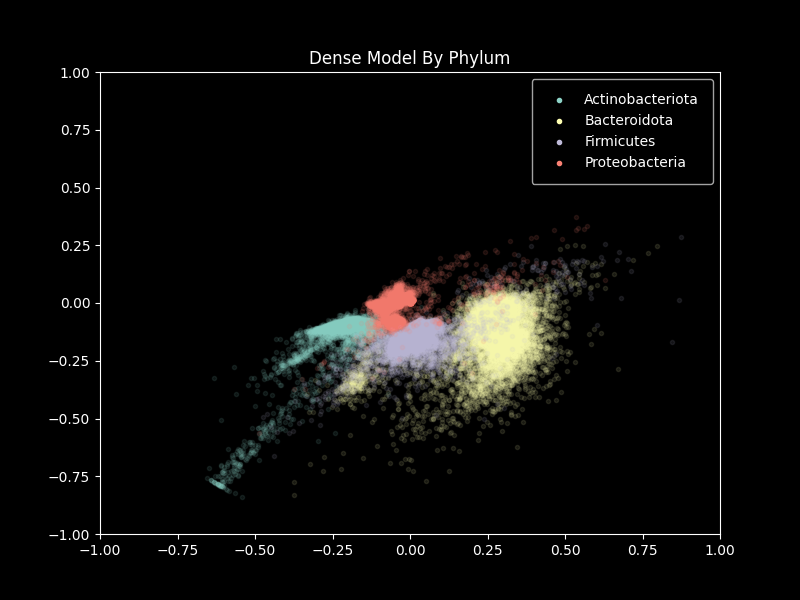

In [20]:
from SeReGen.visualize import reprs_by_ds_label
mask = dataset['labels'].label_mask('Domain', 'Bacteria')
reprs_by_ds_label(dense_reprs, dataset, 'Phylum', 'Dense Model By Phylum', filter=10000, mask=mask, marker='.',
              savepath='out.png', scale=1)
from IPython.display import Image
Image(filename='out.png')

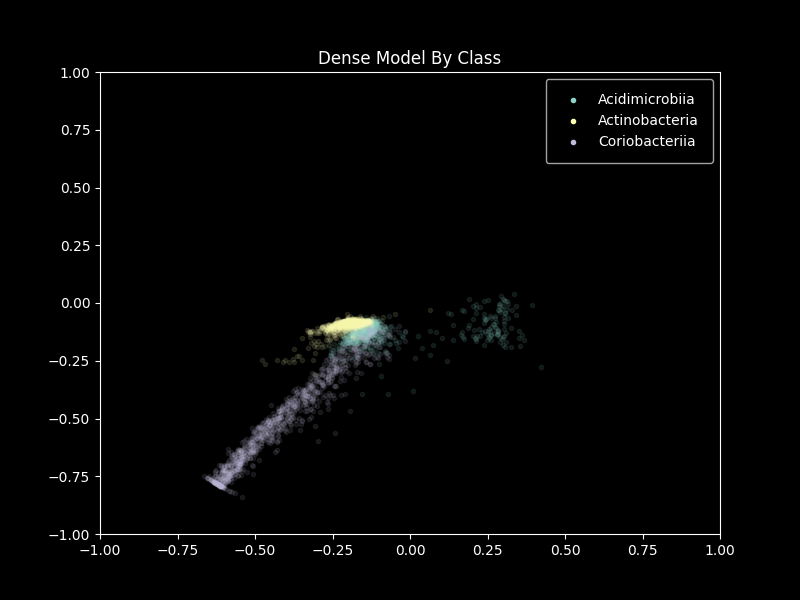

In [21]:
from SeReGen.visualize import reprs_by_ds_label
mask = dataset['labels'].label_mask('Phylum', 'Actinobacteriota')
reprs_by_ds_label(dense_reprs, dataset, 'Class', 'Dense Model By Class', filter=1000, mask=mask, savepath='out.png',
              alpha=.1, marker='.', scale=1)
from IPython.display import Image
Image(filename='out.png')

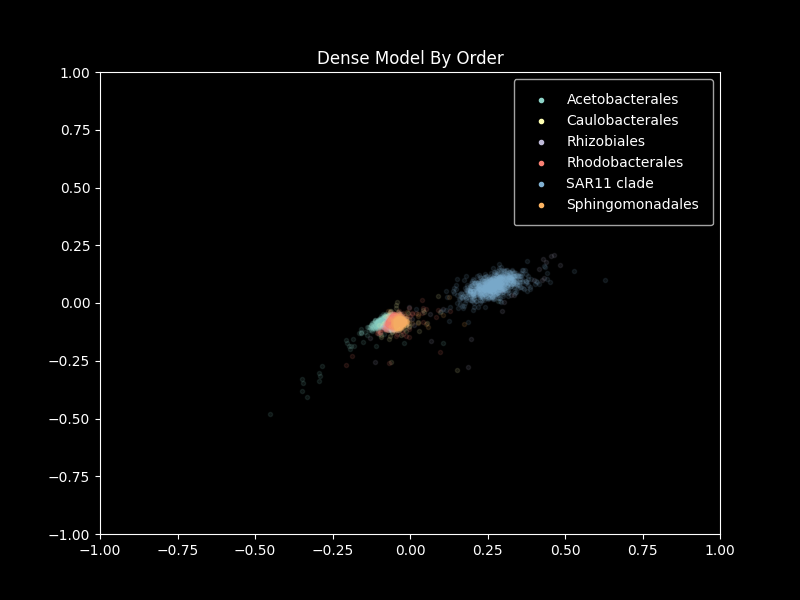

In [22]:
from SeReGen.visualize import reprs_by_ds_label
mask = dataset['labels'].label_mask('Class', 'Alphaproteobacteria')
reprs_by_ds_label(dense_reprs, dataset, 'Order', 'Dense Model By Order', filter=1000, mask=mask, savepath='out.png',
              alpha=.1, marker='.', scale=1)
from IPython.display import Image
Image(filename='out.png')

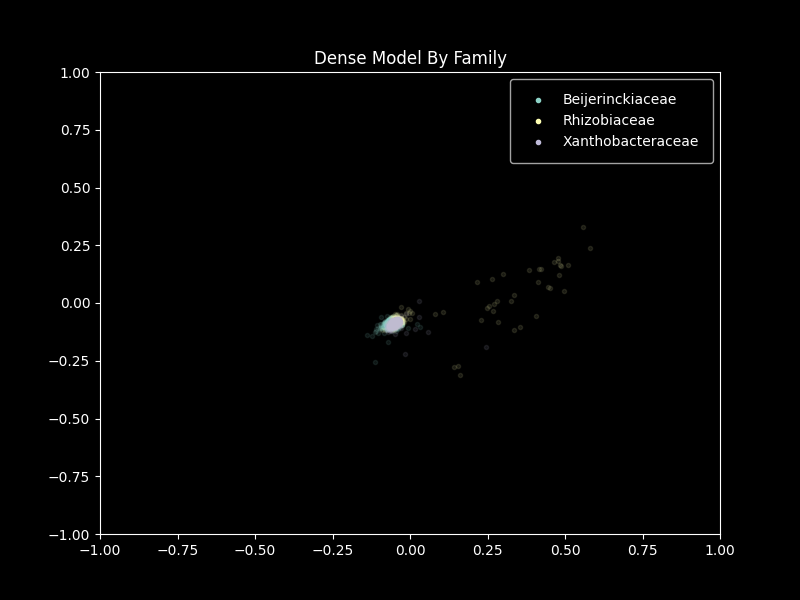

In [23]:
from SeReGen.visualize import reprs_by_ds_label
mask = dataset['labels'].label_mask('Order', 'Rhizobiales')
reprs_by_ds_label(dense_reprs, dataset, 'Family', 'Dense Model By Family', filter=1000, mask=mask, savepath='out.png',
              alpha=.1, marker='.', scale=1)
from IPython.display import Image
Image(filename='out.png')

In [18]:
seqs = []
for _ in range(100):
    generator = SyntheticGenerator(1200, .01)
    seqs.append(generator.gen())

from SeReGen.kmers import KMerCounter
counter = KMerCounter(5)
counts = counter.kmer_counts(seqs)
results = dense_comp.transform(counts, 100)

100%|██████████| 100/100 [00:00<00:00, 3282.96it/s]


1/1 [==============================] - 0s 27ms/step


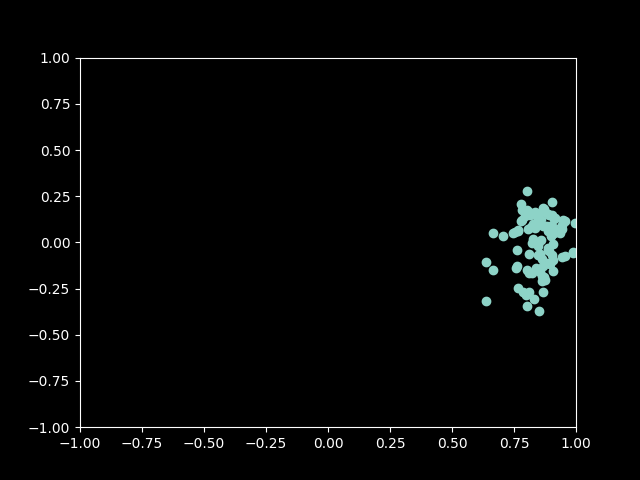

In [24]:
import matplotlib.pyplot as plt
plt.close('all')
plt.scatter(*zip(*results))
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.savefig('out.png')
from IPython.display import Image
Image(filename='out.png')